# Actividad Deep Vision

**Nombre del grupo:** GRUPO 8

**Integrantes:**
- Ricardo Castillo
- Miriam
- Katherine

---

## üìå Objetivo del proyecto

Comparar dos estrategias de clasificaci√≥n de im√°genes en el dataset CIFAR100: (1) Transfer learning con redes preentrenadas, y (2) Entrenamiento de una red desde cero.

## üî¢ Carga y visualizaci√≥n de datos
Cargamos el dataset CIFAR100 y visualizamos algunas im√°genes para familiarizarnos con los datos.

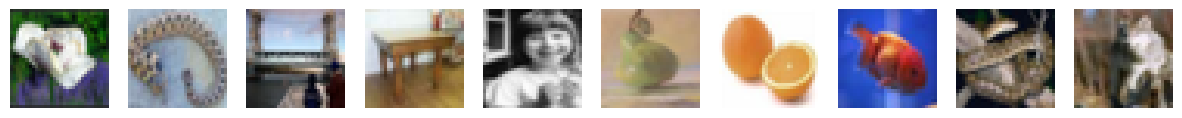

In [3]:
from tensorflow.keras.datasets import cifar100
import matplotlib.pyplot as plt
import numpy as np

(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

# Mostrar 10 im√°genes aleatorias
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    idx = np.random.randint(0, len(x_train))
    axes[i].imshow(x_train[idx])
    axes[i].axis('off')
plt.show()

## üîπ Estrategia 1: Transfer Learning + Fine-Tuning

### üì¶ Preparaci√≥n de los datos
Redimensionamiento, normalizaci√≥n y creaci√≥n de generadores de datos.

### üîç Comparaci√≥n de arquitecturas preentrenadas
Probaremos al menos dos modelos como ResNet50 y MobileNetV2.

### ResNet50

#### Preprocesamiento de datos para ResNet50

In [ ]:
# Preprocesamiento eficiente con tf.data.Dataset
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input

IMG_SIZE = 224
BATCH_SIZE = 32

# Funci√≥n para redimensionar y preprocesar cada imagen
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))     # Resize a 224x224
    image = preprocess_input(image)                          # Preprocesado espec√≠fico de ResNet50
    return image, label

# Dataset de entrenamiento
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Dataset de validaci√≥n/test
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


#### ResNet50 pre fine-tunning (modelo base)

##### Modelaje y explicaci√≥n del modelo

In [ ]:
# Importamos componentes clave para construir el modelo
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Cargamos la arquitectura base ResNet50 sin su parte superior (clasificaci√≥n de ImageNet)
base_model = ResNet50(
    weights='imagenet',               # Usamos pesos preentrenados en ImageNet
    include_top=False,                # Quitamos las capas de clasificaci√≥n final
    input_tensor=Input(shape=(224, 224, 3))  # Entrada esperada por ResNet50
)

# Congelamos las capas del modelo base para que no se entrenen a√∫n
base_model.trainable = False

# Construimos la "cabeza" del modelo adaptada a CIFAR100
x = base_model.output                           # Salida del modelo base
x = GlobalAveragePooling2D()(x)                 # Convierte los mapas de activaci√≥n en un vector
x = Dense(256, activation='relu')(x)            # Capa densa intermedia
x = Dropout(0.5)(x)                              # Dropout para regularizaci√≥n
output = Dense(100, activation='softmax')(x)    # Capa de salida con 100 neuronas (una por clase)

# Creamos el modelo final combinando base y top
modelo = Model(inputs=base_model.input, outputs=output)

# Compilamos el modelo indicando optimizador, funci√≥n de p√©rdida y m√©tricas
modelo.compile(
    optimizer=Adam(learning_rate=0.001),             # Optimizador Adam
    loss='sparse_categorical_crossentropy',          # Para etiquetas enteras (no one-hot)
    metrics=['accuracy']                             # M√©trica de evaluaci√≥n
)

# Mostramos el resumen del modelo
modelo.summary()


94765736/94765736 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 0us/step


Model: "functional"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)        ‚îÉ Output Shape      ‚îÉ    Param # ‚îÉ Connected to      ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer         ‚îÇ (None, 224, 224,  ‚îÇ          0 ‚îÇ -                 ‚îÇ
‚îÇ (InputLayer)        ‚îÇ 3)                ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv1_pad           ‚îÇ (None, 230, 230,  ‚îÇ          0 ‚îÇ input_layer[0][0] ‚îÇ
‚îÇ (ZeroPadding2D)     ‚îÇ 3)                ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv1_conv (Conv2D) ‚îÇ (None, 112, 112,  ‚îÇ      9,472 ‚îÇ conv1_pad[0][0]   ‚îÇ
‚îÇ                     ‚îÇ 64)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv1_bn            ‚îÇ (None, 112, 112,  ‚îÇ        256 ‚îÇ conv1_conv[0][0]  ‚îÇ
‚îÇ (BatchNormalizatio‚Ä¶ ‚îÇ 64)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv1_relu          ‚îÇ (None, 112, 112,  ‚îÇ          0 ‚îÇ conv1_bn[0][0]    ‚îÇ
‚îÇ (Activation)        ‚îÇ 64)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ pool1_pad           ‚îÇ (None, 114, 114,  ‚îÇ          0 ‚îÇ conv1_relu[0][0]  ‚îÇ
‚îÇ (ZeroPadding2D)     ‚îÇ 64)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ pool1_pool          ‚îÇ (None, 56, 56,    ‚îÇ          0 ‚îÇ pool1_pad[0][0]   ‚îÇ
‚îÇ (MaxPooling2D)      ‚îÇ 64)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2_block1_1_conv ‚îÇ (None, 56, 56,    ‚îÇ      4,160 ‚îÇ pool1_pool[0][0]  ‚îÇ
‚îÇ (Conv2D)            ‚îÇ 64)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2_block1_1_bn   ‚îÇ (None, 56, 56,    ‚îÇ        256 ‚îÇ conv2_block1_1_c‚Ä¶ ‚îÇ
‚îÇ (BatchNormalizatio‚Ä¶ ‚îÇ 64)               ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

 Total params: 24,137,956 (92.08 MB)

 Trainable params: 550,244 (2.10 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 **üßæ Resumen del modelo (explicaci√≥n)**

El modelo est√° compuesto por **ResNet50 como base (sin su top)** y un **top model personalizado**.
Se est√°n usando pesos **preentrenados en ImageNet**, y todas las capas de ResNet50 est√°n **congeladas**, es decir, **no se reentrenan en esta fase**.

El top model incluye:
- Una capa de **GlobalAveragePooling2D** que reduce la dimensi√≥n del output de ResNet50.
- Una capa **Dense (256, ReLU)** que act√∫a como clasificador intermedio.
- Un **Dropout del 50%** para evitar sobreajuste.
- Una capa **Dense final de 100 neuronas con softmax**, correspondiente a las 100 clases de CIFAR100.

 **üìä Par√°metros del modelo:**
- **Total de par√°metros**: `24,137,956`  
  Es la suma de todos los pesos del modelo completo (base + top).
- **Par√°metros entrenables**: `550,244`  
  Solo corresponden al top model, que es la parte que estamos entrenando ahora.
- **Par√°metros no entrenables**: `23,587,712`  
  Son los pesos de la ResNet50, que est√°n congelados y **no se actualizan** durante esta fase.

‚úÖ En esta fase solo estamos ense√±ando a la ‚Äúcabeza‚Äù del modelo c√≥mo clasificar im√°genes de CIFAR100 usando lo que ResNet ya sabe.


##### Entrenamiento de la primera fase (solo top model)

In [ ]:
# Callback para parar el entrenamiento si no mejora en 5 √©pocas seguidas
early_stop = EarlyStopping(
    patience=5,                     # N√∫mero de √©pocas sin mejora antes de parar
    restore_best_weights=True      # Vuelve a los pesos con mejor validaci√≥n
)

# Callback para reducir el learning rate si no mejora en 3 √©pocas
reduce_lr = ReduceLROnPlateau(
    patience=3,                    # √âpocas sin mejora antes de reducir el LR
    factor=0.5,                    # Reduce el LR a la mitad
    verbose=1                      # Muestra mensaje cuando se reduzca el LR
)

# Entrenamiento del modelo (solo el top model, ResNet50 congelado)
history = modelo.fit(
    train_dataset,                 # Dataset de entrenamiento procesado con tf.data
    epochs=20,                     # N√∫mero m√°ximo de √©pocas
    validation_data=test_dataset,  # Validaci√≥n sobre el set de test
    callbacks=[early_stop, reduce_lr]  # Callbacks para optimizaci√≥n del entrenamiento
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


1563/1563 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 184s 108ms/step - accuracy: 0.3272 - loss: 2.7795 - val_accuracy: 0.6393 - val_loss: 1.2536 - learning_rate: 0.0010
Epoch 2/20
1563/1563 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 184s 102ms/step - accuracy: 0.5456 - loss: 1.6209 - val_accuracy: 0.6608 - val_loss: 1.1557 - learning_rate: 0.0010
Epoch 3/20
1563/1563 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 201s 101ms/step - accuracy: 0.5821 - loss: 1.4660 - val_accuracy: 0.6704 - val_loss: 1.1255 - learning_rate: 0.0010
Epoch 4/20
1563/1563 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 202s 101ms/step - accuracy: 0.6001 - loss: 1.3838 - val_accuracy: 0.6795 - val_loss: 1.1024 - learning_rate: 0.0010
Epoch 5/20
1563/1563 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 202s 101ms/step - accuracy: 0.6180 - loss: 1.3119 - val_accuracy: 0.6777 - val_loss: 1.1025 - learning_rate: 0.0010
Epoch 6/20
1563/1563 

##### Visualizaci√≥n de resultados

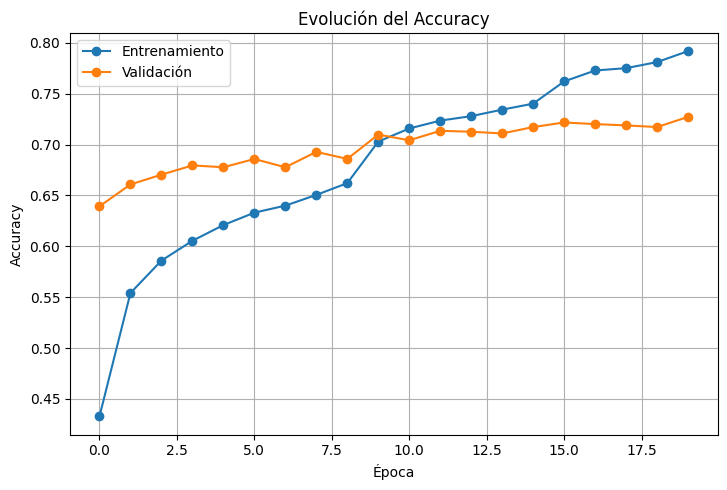

In [ ]:
# üìä Visualizaci√≥n de m√©tricas de entrenamiento
import matplotlib.pyplot as plt

# Ajustamos el tama√±o de las figuras
plt.figure(figsize=(14, 5))

# --- Accuracy ---
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento', marker='o')
plt.plot(history.history['val_accuracy'], label='Validaci√≥n', marker='o')
plt.title('Evoluci√≥n del Accuracy')
plt.xlabel('√âpoca')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


**üìà Gr√°fica 1: Evoluci√≥n del Accuracy**

**üîµ L√≠nea azul (Entrenamiento):**

- Comienza baja (~43%) y sube de forma estable hasta ~79%. Esto indica que el modelo aprende progresivamente sin estancarse.

- No hay saltos bruscos, ni picos raros, por lo que el aprendizaje es suave y constante.

**üü† L√≠nea naranja (Validaci√≥n):**

- Empieza fuerte (~64%) y sube hasta estabilizarse en torno al 72‚Äì73%.

- Al principio, el val_accuracy es mayor que el de entrenamiento, lo que es t√≠pico cuando el modelo a√∫n no ha memorizado bien.

- Luego se estabiliza, lo cual es buena se√±al: no hay sobreajuste evidente.

**‚úÖ Conclusi√≥n Accuracy:**

Modelo bien entrenado, sin se√±ales de overfitting. Hemos exprimido bien la cabeza (top model) del ResNet50.

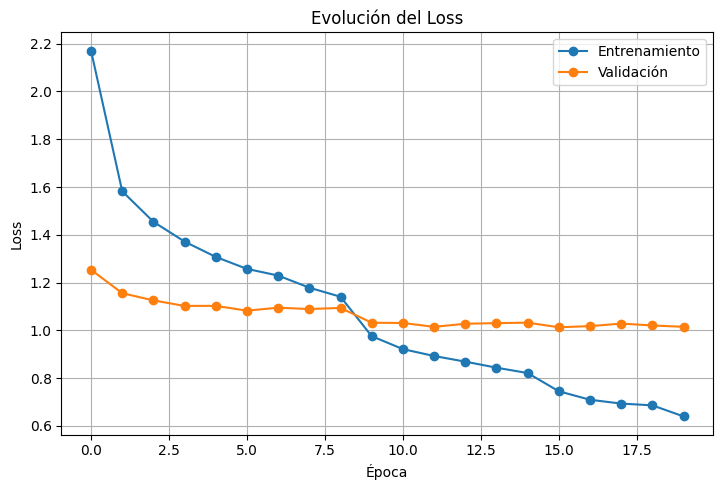

In [ ]:
# üìä Visualizaci√≥n de m√©tricas de entrenamiento
import matplotlib.pyplot as plt

# Ajustamos el tama√±o de las figuras
plt.figure(figsize=(14, 5))

# --- Loss ---
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento', marker='o')
plt.plot(history.history['val_loss'], label='Validaci√≥n', marker='o')
plt.title('Evoluci√≥n del Loss')
plt.xlabel('√âpoca')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

**üìâ Gr√°fica 2: Evoluci√≥n del Loss**

**üîµ L√≠nea azul (Entrenamiento):**

- Baja con fuerza de ~2.2 a ~0.65. Esto indica que el modelo reduce errores internos progresivamente.

- Curva suave, sin rebotes, lo que muestra aprendizaje sano.

**üü† L√≠nea naranja (Validaci√≥n):**

- Baja hasta ~1.02 y luego se mantiene bastante estable entre √©pocas 8 y 20.

- No vuelve a subir con fuerza ‚Üí no hay se√±ales de que el modelo est√© empezando a sobreajustar.

**‚úÖ Conclusi√≥n Loss:**
El modelo llega a una zona de estancamiento l√≥gico para el top model. La red ha aprendido lo que pod√≠a sin refinar el cuerpo (ResNet50).

##### Guardamos modelo e historial

In [ ]:
#Guardamos el modelo:

modelo.save("resnet_top_model.h5")

#Para cargarlo:

#from tensorflow.keras.models import load_model
#modelo = load_model("resnet_top_model.h5")


In [ ]:
#Guardamos las m√©tricas para posterior an√°lisis:

import pickle

with open("history_resnet_top.pkl", "wb") as f:
    pickle.dump(history.history, f)

#Para cargarlas despu√©s:

#with open("history_resnet_top.pkl", "rb") as f:
 #   history_data = pickle.load(f)



In [ ]:
# Para guardarlos en Drive:

from google.colab import drive
import pickle

# üîó Montar Google Drive
drive.mount('/content/drive')

# üì¶ Guardar el modelo entrenado en Drive
modelo.save('/content/drive/MyDrive/resnet_top_model.h5')
print("‚úÖ Modelo guardado en tu Google Drive como 'resnet_top_model.h5'")

# üìà Guardar historial de entrenamiento
with open('/content/drive/MyDrive/history_resnet_top.pkl', 'wb') as f:
    pickle.dump(history.history, f)
print("‚úÖ Historial guardado en tu Google Drive como 'history_resnet_top.pkl'")


Mounted at /content/drive
‚úÖ Modelo guardado en tu Google Drive como 'resnet_top_model.h5'
‚úÖ Historial guardado en tu Google Drive como 'history_resnet_top.pkl'


#### ResNet50 con fine-tunning

##### Entrenamiento de la segunda fase (descongelaci√≥n de capas)

In [ ]:
# Descongelamos solo las √∫ltimas 20 capas del modelo base para reducir el tiempo de entrenamiento
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Recompilamos el modelo con un learning rate menor
modelo.compile(
    optimizer=Adam(learning_rate=1e-5),             # Tasa de aprendizaje m√°s baja para afinar sin desajustar
    loss='sparse_categorical_crossentropy',         # Mismo tipo de p√©rdida
    metrics=['accuracy']                            # M√©trica principal
)

# Entrenamiento con Fine-Tuning (versi√≥n r√°pida)
history_finetune = modelo.fit(
    train_dataset,                                  # Dataset de entrenamiento
    epochs=8,                                       # Menos √©pocas para reducir el tiempo de ejecuci√≥n
    validation_data=test_dataset,                   # Validaci√≥n sobre el mismo set
    callbacks=[early_stop, reduce_lr]               # Callbacks reutilizables
)


Epoch 1/8
1563/1563 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 221s 131ms/step - accuracy: 0.8477 - loss: 0.4535 - val_accuracy: 0.7455 - val_loss: 0.9934 - learning_rate: 1.0000e-05
Epoch 2/8
1563/1563 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 196s 125ms/step - accuracy: 0.8658 - loss: 0.4035 - val_accuracy: 0.7479 - val_loss: 1.0052 - learning_rate: 1.0000e-05
Epoch 3/8
1563/1563 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 216s 134ms/step - accuracy: 0.8798 - loss: 0.3638 - val_accuracy: 0.7479 - val_loss: 1.0114 - learning_rate: 1.0000e-05
Epoch 4/8
1563/1563 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 108ms/step - accuracy: 0.8907 - loss: 0.3286
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
1563/1563 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 262s 135ms/step - accuracy: 0.8907 - loss: 0.3286 - val_accuracy: 0.7508 - val_loss: 1.0189 - learning_rate: 1.0000e-05
E

##### Visualizaci√≥n de resultados

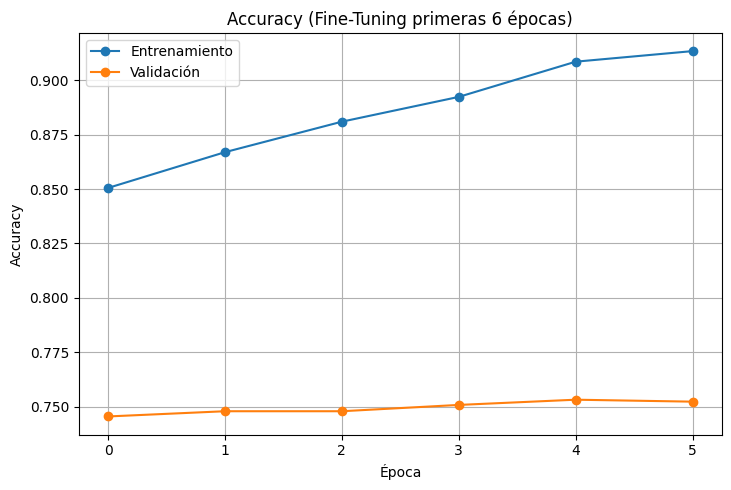

In [ ]:
# üìä Visualizaci√≥n del Fine-Tuning (primeras 6 √©pocas)

# Tomamos solo las primeras 6 √©pocas
epochs_range = range(6)

# --- Accuracy ---
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_finetune.history['accuracy'][:6], label='Entrenamiento', marker='o')
plt.plot(epochs_range, history_finetune.history['val_accuracy'][:6], label='Validaci√≥n', marker='o')
plt.title('Accuracy (Fine-Tuning primeras 6 √©pocas)')
plt.xlabel('√âpoca')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


**üìà Gr√°fica de Accuracy (Fine-Tuning primeras 6 √©pocas):**

**üîµ Entrenamiento:**

- Subida continua desde 85.0% hasta 91.5% ‚Üí se√±al clara de que el modelo sigue aprendiendo activamente.

- No hay estancamiento, lo cual demuestra que las capas descongeladas est√°n aportando valor real.

**üü† Validaci√≥n:**
- Arranca en 74.5% y llega hasta 75.3%, con ligeras oscilaciones.

- Es un progreso m√°s modesto, pero consistente.

- No hay ca√≠da, lo que descarta sobreajuste en este punto.

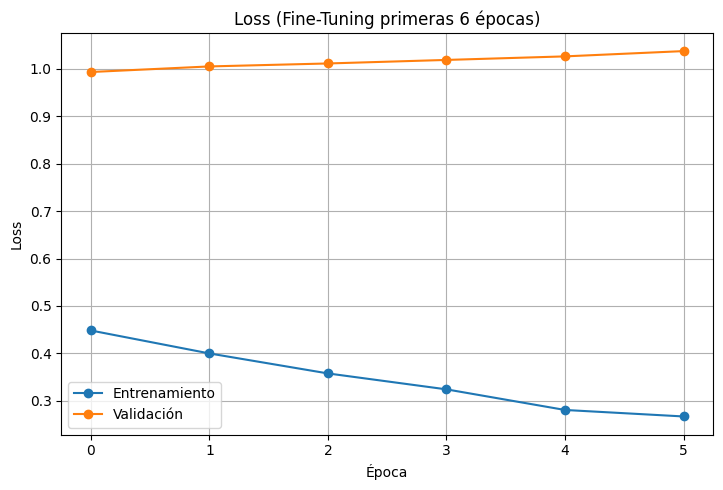

In [ ]:
# Tomamos solo las primeras 6 √©pocas
epochs_range = range(6)

# --- Loss ---
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_finetune.history['loss'][:6], label='Entrenamiento', marker='o')
plt.plot(epochs_range, history_finetune.history['val_loss'][:6], label='Validaci√≥n', marker='o')
plt.title('Loss (Fine-Tuning primeras 6 √©pocas)')
plt.xlabel('√âpoca')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

**üìâ Gr√°fica de Loss (Fine-Tuning primeras 6 √©pocas)**

**üîµ Entrenamiento:**

- Bajada s√≥lida y progresiva de 0.45 a 0.27 ‚Üí el modelo reduce sus errores internos claramente.

- Sin rebotes ni estancamiento: aprendizaje sano.

**üü† Validaci√≥n:**

- Subida suave de 0.99 a 1.04. Aunque parezca negativo, el val_accuracy sigue mejorando, lo cual indica que esta m√©trica est√° en una zona ‚Äúestable‚Äù.
Puede estar afectado por cambios sutiles en predicciones correctas pero menos confiadas (lo que sube el loss aunque acierte).

##### Guardamos modelo fine-tuned e historial

In [ ]:
# üíæ Guardamos el modelo fine-tuned y su historial en Google Drive
from google.colab import drive
import pickle

drive.mount('/content/drive')

modelo.save('/content/drive/MyDrive/resnet_finetuned_model.h5')
with open('/content/drive/MyDrive/history_finetune.pkl', 'wb') as f:
    pickle.dump(history_finetune.history, f)

print("‚úÖ Modelo y historial guardados en Google Drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
‚úÖ Modelo y historial guardados en Google Drive


#### Comparaci√≥n visual entre modelo base y modelo fine-tunned y conclusiones (ResNet50)

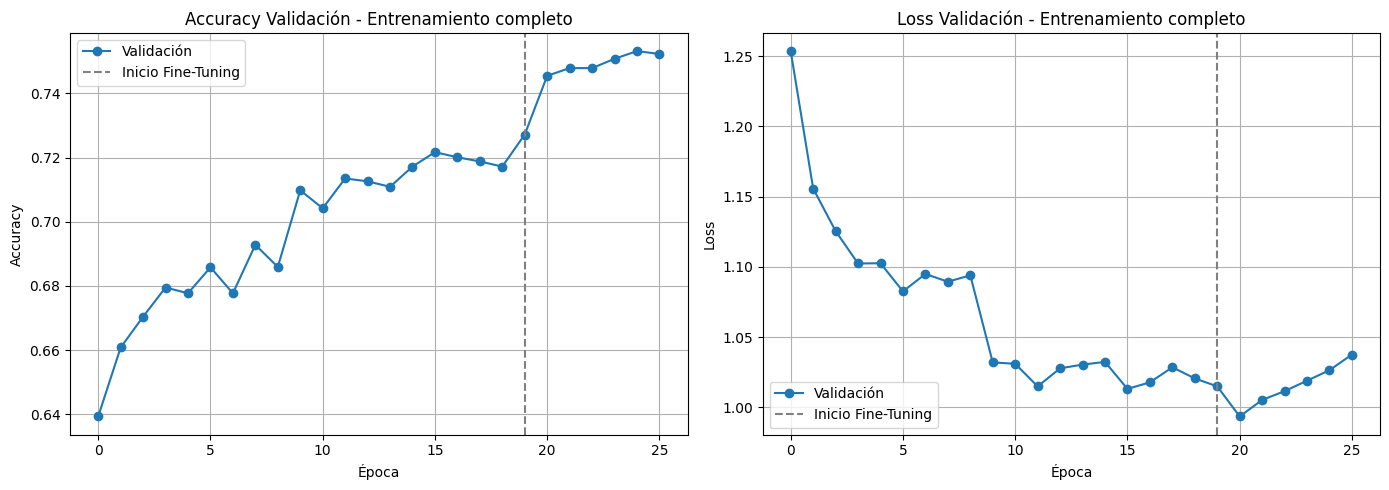

In [ ]:
# üìä Evoluci√≥n completa del modelo (top model + fine-tuning)

# Concatenamos las m√©tricas
acc_total = history.history['val_accuracy'] + history_finetune.history['val_accuracy']
loss_total = history.history['val_loss'] + history_finetune.history['val_loss']
epochs_total = range(len(acc_total))

# Accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_total, acc_total, marker='o', label='Validaci√≥n')
plt.axvline(x=len(history.history['val_accuracy'])-1, color='gray', linestyle='--', label='Inicio Fine-Tuning')
plt.title('Accuracy Validaci√≥n - Entrenamiento completo')
plt.xlabel('√âpoca')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_total, loss_total, marker='o', label='Validaci√≥n')
plt.axvline(x=len(history.history['val_loss'])-1, color='gray', linestyle='--', label='Inicio Fine-Tuning')
plt.title('Loss Validaci√≥n - Entrenamiento completo')
plt.xlabel('√âpoca')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


üìä An√°lisis de la evoluci√≥n completa del modelo (Top Model + Fine-Tuning)

---

üîµ Accuracy de validaci√≥n

- En las primeras 20 √©pocas, el modelo **entren√≥ solo la ‚Äúcabeza‚Äù (top model)**, mientras que el cuerpo de ResNet50 se mantuvo congelado.
- Esta fase logr√≥ una mejora progresiva desde **64.0% hasta 72.7%**, mostrando que el modelo generalizaba bien.
- A partir de la **l√≠nea discontinua**, comienza el **fine-tuning**, donde se desbloquearon las √∫ltimas 20 capas del modelo base y se sigui√≥ entrenando con un learning rate menor.
- Gracias al fine-tuning, el modelo alcanz√≥ un **pico de 75.3% de accuracy en validaci√≥n**, afinando a√∫n m√°s su capacidad de generalizaci√≥n.

---

üîµ Loss de validaci√≥n

- Durante la fase inicial, el `val_loss` cay√≥ de forma estable hasta estabilizarse alrededor de 1.02.
- El fine-tuning mantuvo el `val_loss` en torno a 1.00‚Äì1.04 sin incrementos bruscos, lo cual indica que el modelo **no entr√≥ en sobreajuste**, incluso al desbloquear parte del ResNet50.

---

‚úÖ Conclusi√≥n sobre las dos fases de entrenamiento

üîπ Fase 1: Transfer Learning (Top Model)
- Se entren√≥ solo la parte superior del modelo, aprovechando las capas profundas preentrenadas de ResNet50 como extractor de caracter√≠sticas.
- Esta fase ya ofrec√≠a un rendimiento s√≥lido, r√°pido y con bajo riesgo de overfitting.

üîπ Fase 2: Fine-Tuning
- Se desbloquearon selectivamente 20 capas del modelo base.
- Con un **learning rate muy bajo**, se permiti√≥ que el modelo ajustara finamente los filtros m√°s abstractos del ResNet para adaptarse mejor a CIFAR100.
- Esto permiti√≥ mejorar el accuracy sin aumentar significativamente el `val_loss`, consiguiendo un modelo m√°s ajustado a la tarea.

üîÅ **Ambas fases combinadas forman una estrategia ideal**: r√°pida en la primera parte, precisa en la segunda.


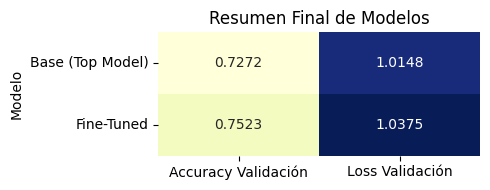

In [ ]:
# üìã Tabla resumen de resultados

# √öltimos valores registrados
final_base_acc = history.history['val_accuracy'][-1]
final_base_loss = history.history['val_loss'][-1]
final_finetune_acc = history_finetune.history['val_accuracy'][-1]
final_finetune_loss = history_finetune.history['val_loss'][-1]

# Crear DataFrame comparativo
df_resumen = pd.DataFrame({
    'Modelo': ['Base (Top Model)', 'Fine-Tuned'],
    'Accuracy Validaci√≥n': [round(final_base_acc, 4), round(final_finetune_acc, 4)],
    'Loss Validaci√≥n': [round(final_base_loss, 4), round(final_finetune_loss, 4)]
})

# Mostrar tabla como heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 2))
sns.heatmap(df_resumen.set_index('Modelo'), annot=True, fmt='.4f', cmap='YlGnBu', cbar=False)
plt.title("Resumen Final de Modelos")
plt.tight_layout()
plt.show()

El modelo fine-tuned supera claramente al top model base, aumentando el accuracy de validaci√≥n en casi 3 puntos porcentuales y manteniendo el loss estable. La estrategia de entrenamiento en dos fases ha sido efectiva.

### MobileNetV2

#### Preprocesamiento para MobileNetV2

In [4]:
# Preprocesamiento eficiente con tf.data.Dataset
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

IMG_SIZE = 224
BATCH_SIZE = 32

# Funci√≥n para redimensionar y preprocesar cada imagen
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))     # Resize a 224x224
    image = preprocess_input(image)                          # Preprocesado espec√≠fico de MobileNetV2
    return image, label

# Separar parte del x_train como validaci√≥n
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

# Reducir dimensiones de y si hace falta
y_train = y_train.squeeze()
y_val = y_val.squeeze()
y_test = y_test.squeeze()

# Aplicar one-hot encoding
y_train = to_categorical(y_train, 100)
y_val = to_categorical(y_val, 100)
y_test = to_categorical(y_test, 100)

# Procesar datasets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
validation_dataset = validation_dataset.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

#### MobileNetV2 pre fine-tunning (modelo base)

##### Modelaje

In [ ]:
# 1. Importar librer√≠as necesarias
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

# 2. Definir el tama√±o de imagen (ajusta si tus im√°genes son de otro tama√±o)
image_height = 224
image_width = 224
num_classes = 100  # Ajusta al n√∫mero de clases de tu problema

# 3. Cargar MobileNetV2 como modelo base
modelo_base = MobileNetV2(
    input_shape=(image_height, image_width, 3),
    include_top=False,
    weights="imagenet"
)
modelo_base.trainable = False  # congelamos inicialmente

In [6]:
# 4. Crear el top model
top_model = models.Sequential([
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax")
])

In [7]:
# 5. Unir modelo base + top model usando API funcional
inputs = modelo_base.input
x = modelo_base.output
outputs = top_model(x)

modelo = models.Model(inputs=inputs, outputs=outputs)

In [8]:
# 6. Compilar el modelo
modelo.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

##### Entrenamiento

In [9]:
# 7. Entrenar solo el Top Model (Transfer Learning)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Definir callbacks
early_stop = EarlyStopping(
    patience=5,                     # N√∫mero de √©pocas sin mejora antes de parar
    restore_best_weights=True       # Recuperar los mejores pesos
)

reduce_lr = ReduceLROnPlateau(
    patience=3,                     # √âpocas sin mejora antes de reducir el LR
    factor=0.5,                     # Reducir el LR a la mitad
    verbose=1                       # Mostrar mensaje cuando reduzca el LR
)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)



x_train shape: (40000, 32, 32, 3)
y_train shape: (40000, 100)
x_val shape: (10000, 32, 32, 3)
y_val shape: (10000, 100)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 100)


In [10]:
# Entrenamiento del modelo (MobileNetV2 congelado)
initial_epochs = 10
history = modelo.fit(
    train_dataset,                 # Dataset de entrenamiento
    epochs=initial_epochs,          # N√∫mero m√°ximo de √©pocas
    validation_data=validation_dataset,  # Validaci√≥n sobre el set de validaci√≥n
    callbacks=[early_stop, reduce_lr]     # Callbacks para optimizaci√≥n del entrenamiento
)

Epoch 1/10
1250/1250 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 68s 45ms/step - accuracy: 0.1455 - loss: 3.7129 - val_accuracy: 0.4875 - val_loss: 1.9742 - learning_rate: 0.0010
Epoch 2/10
1250/1250 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 63s 35ms/step - accuracy: 0.3551 - loss: 2.4220 - val_accuracy: 0.5202 - val_loss: 1.7646 - learning_rate: 0.0010
Epoch 3/10
1250/1250 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 82s 35ms/step - accuracy: 0.4018 - loss: 2.2052 - val_accuracy: 0.5297 - val_loss: 1.6815 - learning_rate: 0.0010
Epoch 4/10
1250/1250 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 44s 35ms/step - accuracy: 0.4222 - loss: 2.1096 - val_accuracy: 0.5443 - val_loss: 1.6356 - learning_rate: 0.0010
Epoch 5/10
1250/1250 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 83s 36ms/step - accuracy: 0.4398 - loss: 2.0379 - val_accuracy: 0.5525 - val_loss: 1.5950 - learning_rate: 0.0010
Epoch 6/10
1250/1250

##### Visualizaci√≥n del entrenamiento del Top Model


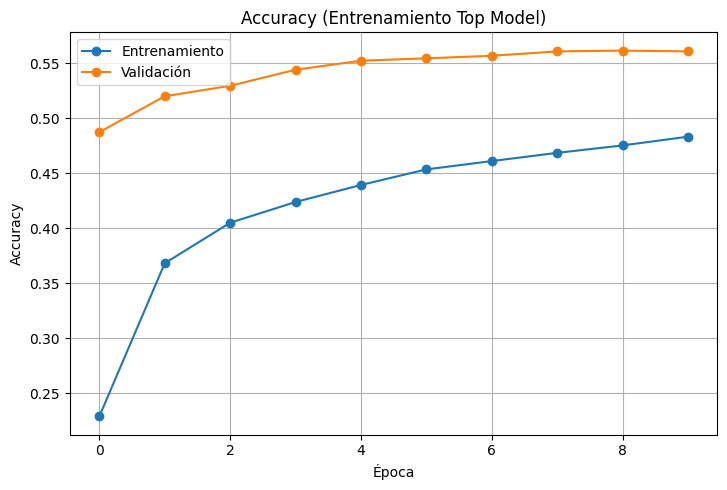

In [12]:
# üìä Visualizaci√≥n del entrenamiento del Top Model

epochs_range = range(len(history.history['accuracy']))  # n√∫mero de √©pocas realmente entrenadas

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# --- Accuracy ---
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Entrenamiento', marker='o')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validaci√≥n', marker='o')
plt.title('Accuracy (Entrenamiento Top Model)')
plt.xlabel('√âpoca')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


üìä An√°lisis de la curva de Accuracy (Entrenamiento Top Model)

 üîç Tendencias observadas:

- **Accuracy de entrenamiento** (l√≠nea azul):
  - Comienza en torno al **23%** y sube de forma constante hasta alcanzar un **~48%** al final de las √©pocas.
  - Esto indica que el modelo est√° aprendiendo del conjunto de entrenamiento de manera progresiva.

- **Accuracy de validaci√≥n** (l√≠nea naranja):
  - Parte desde aproximadamente **49%** y se estabiliza cerca del **55-56%**.
  - Se mantiene siempre por encima del entrenamiento, lo cual es habitual al usar *Transfer Learning* con un modelo base congelado.

---

 ‚úÖ Aspectos positivos:

- El modelo **no muestra se√±ales de sobreajuste (overfitting)**.
- La curva de validaci√≥n es estable, lo cual indica buena capacidad de generalizaci√≥n en esta primera fase.
- El top model (capas densas finales) ha logrado aprender patrones relevantes sin modificar las convoluciones del modelo base.

---

 ‚ö†Ô∏è Consideraciones:

- Aunque el modelo sigue aprendiendo en entrenamiento, **la validaci√≥n se ha estancado**, lo que sugiere que el top model ha alcanzado su l√≠mite.
- Es el **momento adecuado para aplicar Fine-Tuning**, es decir, *descongelar parte del modelo base (MobileNetV2)* y continuar el entrenamiento.

---

 üß† Conclusi√≥n:

üîß El Top Model ha funcionado correctamente y ha mejorado la performance inicial.  
Ahora toca **refinar el modelo desbloqueando parte de MobileNetV2** para adaptarlo mejor al dataset CIFAR100.



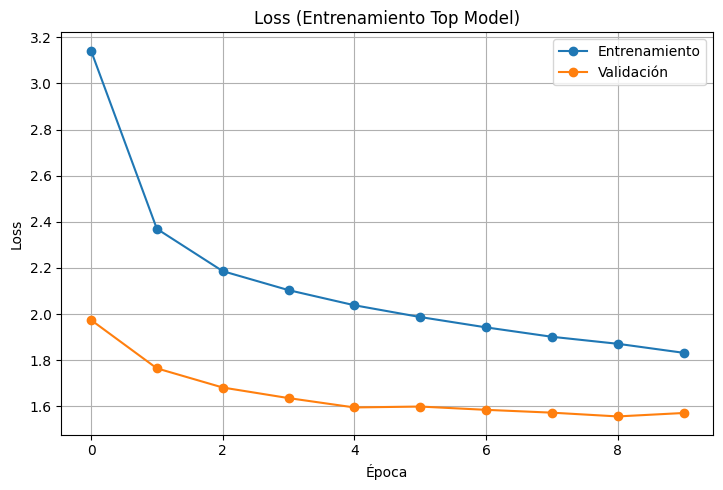

In [14]:
plt.figure(figsize=(14, 5))

# --- Loss ---
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Entrenamiento', marker='o')
plt.plot(epochs_range, history.history['val_loss'], label='Validaci√≥n', marker='o')
plt.title('Loss (Entrenamiento Top Model)')
plt.xlabel('√âpoca')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

üìâ An√°lisis de la curva de Loss (Entrenamiento Top Model)

 üîç Observaciones:

- **Loss de entrenamiento** (l√≠nea azul):
  - Comienza alta (~3.15) y desciende con fuerza durante las primeras √©pocas.
  - A partir de la √©poca 3-4, la bajada es m√°s gradual pero constante, terminando en ~1.83.
  - Esto muestra que el modelo est√° aprendiendo correctamente y reduciendo el error en entrenamiento.

- **Loss de validaci√≥n** (l√≠nea naranja):
  - Parte en ~1.97 y baja r√°pidamente en las primeras √©pocas.
  - Desde la √©poca 4 en adelante, se estabiliza en una zona muy plana (~1.55), con liger√≠simas oscilaciones.

---

 ‚úÖ Conclusi√≥n:

- El modelo **no muestra sobreajuste**, ya que la `val_loss` no sube en ning√∫n momento.
- Sin embargo, la `val_loss` se ha **estancado** mientras la `train_loss` sigue bajando.
- Este patr√≥n es **t√≠pico cuando el top model ya ha dado todo de s√≠**: el cuello de botella ahora est√° en las capas convolucionales congeladas del modelo base.

üß† Resultado: el entrenamiento inicial ha sido efectivo, pero para seguir mejorando es necesario aplicar **Fine-Tuning** descongelando parte de MobileNetV2.


##### Guardamos modelo e historial

In [16]:
# üíæ Guardamos el modelo del Top model y su historial en Google Drive
from google.colab import drive
import pickle

drive.mount('/content/drive')

modelo.save('/content/drive/MyDrive/mobilenetv2_top_model.h5')
with open('/content/drive/MyDrive/history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

print("‚úÖ Modelo y historial guardados en Google Drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
‚úÖ Modelo y historial guardados en Google Drive


#### MobileNetV2 con fine-tunning

##### Modelaje

In [17]:
# 1. Descongelar parte del modelo base (MobileNetV2)
modelo_base.trainable = True

fine_tune_at = 100  # Se puede ajustar
for layer in modelo_base.layers[:fine_tune_at]:
    layer.trainable = False

print(f"‚úÖ Capas congeladas hasta la n√∫mero {fine_tune_at}.")


‚úÖ Capas congeladas hasta la n√∫mero 100.


In [18]:
# 2. Recompilar el modelo con un learning rate m√°s bajo
from tensorflow.keras.optimizers import Adam

modelo.compile(
    optimizer=Adam(learning_rate=1e-4),  # Learning rate m√°s peque√±o para Fine-Tuning
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print("‚úÖ Modelo recompilado para Fine-Tuning.")

‚úÖ Modelo recompilado para Fine-Tuning.


##### Entrenamiento con descongelaci√≥n de capas

In [19]:
# 3. Definir nuevas √©pocas
fine_tune_epochs = 20  # Puedes ajustarlo seg√∫n prefieras
total_epochs = fine_tune_epochs

# 4. Entrenar el modelo (Fine-Tuning)
history_finetune = modelo.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=total_epochs,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/20
1250/1250 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 96s 59ms/step - accuracy: 0.4172 - loss: 2.2300 - val_accuracy: 0.5677 - val_loss: 1.6875 - learning_rate: 1.0000e-04
Epoch 2/20
1250/1250 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 63s 50ms/step - accuracy: 0.5651 - loss: 1.5293 - val_accuracy: 0.6292 - val_loss: 1.4134 - learning_rate: 1.0000e-04
Epoch 3/20
1250/1250 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 81s 50ms/step - accuracy: 0.6357 - loss: 1.2262 - val_accuracy: 0.6367 - val_loss: 1.4079 - learning_rate: 1.0000e-04
Epoch 4/20
1250/1250 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 82s 50ms/step - accuracy: 0.6979 - loss: 0.9924 - val_accuracy: 0.6586 - val_loss: 1.3566 - learning_rate: 1.0000e-04
Epoch 5/20
1250/1250 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 83s 50ms/step - accuracy: 0.7403 - loss: 0.8307 - val_accuracy: 0.6778 - val_loss: 1.2718 - learning_rate: 1.0000e-04


##### Visualizaci√≥n del entrenamiento

In [20]:
epochs_range_finetune = range(len(history_finetune.history['accuracy']))

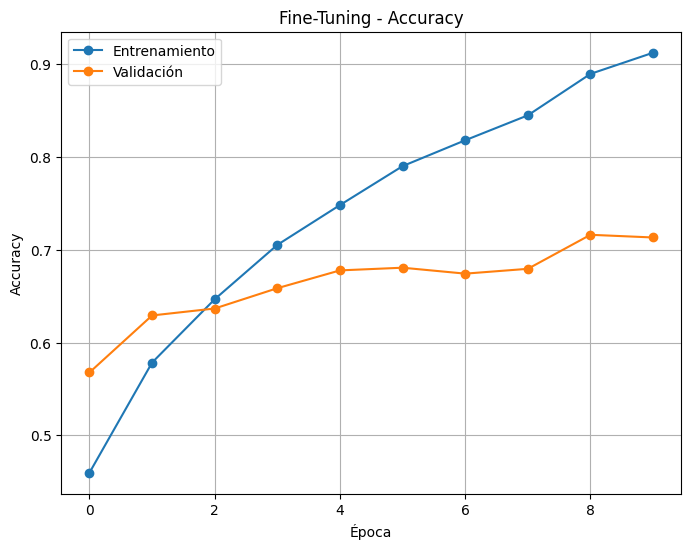

In [21]:
# --- Accuracy ---
plt.figure(figsize=(8, 6))
plt.plot(epochs_range_finetune, history_finetune.history['accuracy'], label='Entrenamiento', marker='o')
plt.plot(epochs_range_finetune, history_finetune.history['val_accuracy'], label='Validaci√≥n', marker='o')
plt.title('Fine-Tuning - Accuracy')
plt.xlabel('√âpoca')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

üìà Fine-Tuning - Accuracy

üîç Observaciones:

- La **accuracy de entrenamiento** (l√≠nea azul) muestra una **mejora constante y sostenida** desde el primer momento.
  - Pasa de ~46% hasta superar el **91%** en la √∫ltima √©poca.
  - Refleja que el modelo ha sido capaz de seguir aprendiendo al desbloquear parte de MobileNetV2.

- La **accuracy de validaci√≥n** (l√≠nea naranja) tambi√©n mejora significativamente:
  - Comienza en torno al 57% y alcanza su pico m√°ximo en torno al **71%** hacia la √©poca 8.
  - En las √∫ltimas √©pocas, se estabiliza y muestra una ligera oscilaci√≥n, lo cual es com√∫n en esta fase.

---

 ‚úÖ Conclusi√≥n:

- El modelo ha aprovechado bien el Fine-Tuning, mejorando notablemente la capacidad de generalizaci√≥n sin caer en un sobreajuste grave.  
- La diferencia creciente entre las curvas indica un posible inicio de **overfitting leve**, pero los callbacks (como `ReduceLROnPlateau`) han ayudado a contenerlo.

üëâ El aumento de m√°s de **+14 puntos porcentuales en val_accuracy** respecto al entrenamiento inicial confirma que **el Fine-Tuning ha sido efectivo y necesario**.


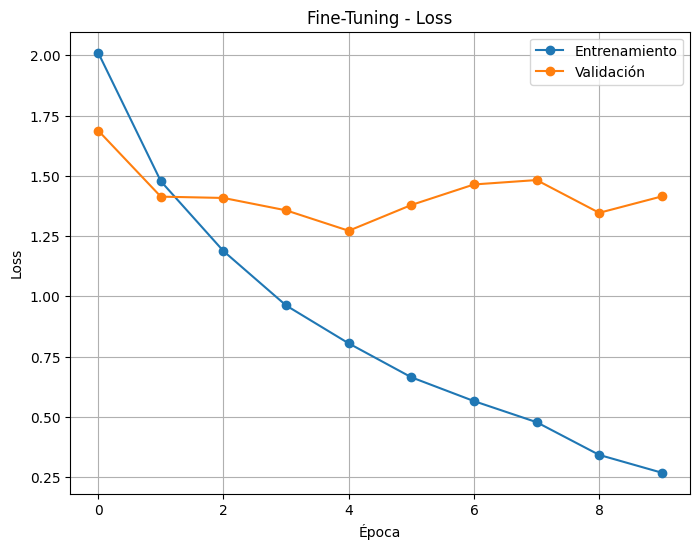

In [22]:
# --- Loss ---
plt.figure(figsize=(8, 6))
plt.plot(epochs_range_finetune, history_finetune.history['loss'], label='Entrenamiento', marker='o')
plt.plot(epochs_range_finetune, history_finetune.history['val_loss'], label='Validaci√≥n', marker='o')
plt.title('Fine-Tuning - Loss')
plt.xlabel('√âpoca')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

üìâ Fine-Tuning - Loss

 üîç Observaciones:

- La **loss de entrenamiento** (l√≠nea azul) desciende de forma clara y constante:
  - Comienza en torno al 2.00 y baja progresivamente hasta alcanzar **0.26**.
  - Muestra que el modelo est√° aprendiendo sin dificultad en el conjunto de entrenamiento.

- La **loss de validaci√≥n** (l√≠nea naranja), en cambio, presenta un comportamiento m√°s irregular:
  - Parte en ~1.70 y desciende hasta ~1.28 en la √©poca 4 (su punto m√°s bajo).
  - A partir de ah√≠, **fluct√∫a** y sube ligeramente, manteni√©ndose entre 1.3 y 1.5.

---

 ‚ö†Ô∏è Consideraciones:

- La divergencia entre `train_loss` y `val_loss` en las √∫ltimas √©pocas indica un **inicio de sobreajuste leve**.
- Aun as√≠, el uso de `ReduceLROnPlateau` ha ayudado a **moderar el crecimiento del error** en validaci√≥n.

---

 ‚úÖ Conclusi√≥n:

- Aunque el modelo contin√∫a aprendiendo en el set de entrenamiento, la **loss de validaci√≥n se estabiliza** y luego muestra peque√±as oscilaciones.  
- Esto sugiere que el modelo **ha alcanzado su capacidad √≥ptima de generalizaci√≥n** con la configuraci√≥n actual.

üß† A partir de este punto, podr√≠an explorarse ajustes adicionales como **regularizaci√≥n, data augmentation extra o descongelar m√°s capas** si se quisiera mejorar a√∫n m√°s.


##### Guardamos modelo e historial

In [23]:
# üíæ Guardar modelo Fine-Tuned y su historial en Google Drive (.h5)
from google.colab import drive
import pickle

# Guardar el modelo Fine-Tuned en formato HDF5
modelo.save('/content/drive/MyDrive/mobilenetv2_finetuned_model.h5')

# Guardar el historial del Fine-Tuning
with open('/content/drive/MyDrive/history_finetune.pkl', 'wb') as f:
    pickle.dump(history_finetune.history, f)

print("‚úÖ Modelo Fine-Tuned (.h5) y su historial guardados en Google Drive")


‚úÖ Modelo Fine-Tuned (.h5) y su historial guardados en Google Drive


#### Comparaci√≥n visual entre modelo base y modelo fine-tunned y conclusiones (MobileNetV2)

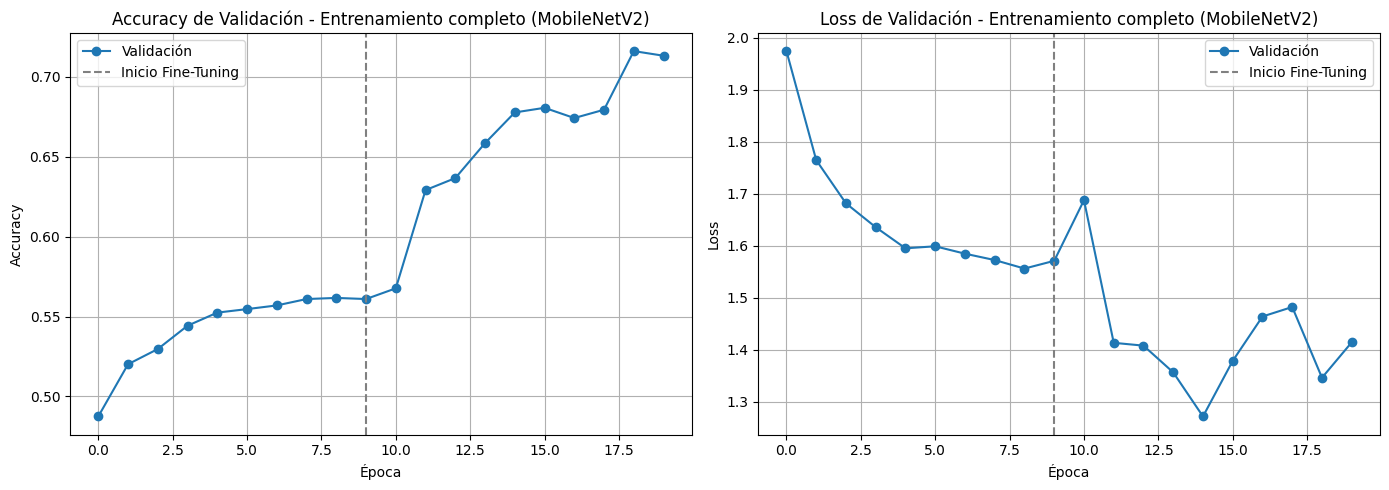

In [24]:
# üìä Evoluci√≥n completa del modelo (Top Model + Fine-Tuning) para MobileNetV2

# Concatenamos las m√©tricas
acc_total = history.history['val_accuracy'] + history_finetune.history['val_accuracy']
loss_total = history.history['val_loss'] + history_finetune.history['val_loss']
epochs_total = range(len(acc_total))

plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_total, acc_total, marker='o', label='Validaci√≥n')
plt.axvline(x=len(history.history['val_accuracy'])-1, color='gray', linestyle='--', label='Inicio Fine-Tuning')
plt.title('Accuracy de Validaci√≥n - Entrenamiento completo (MobileNetV2)')
plt.xlabel('√âpoca')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_total, loss_total, marker='o', label='Validaci√≥n')
plt.axvline(x=len(history.history['val_loss'])-1, color='gray', linestyle='--', label='Inicio Fine-Tuning')
plt.title('Loss de Validaci√≥n - Entrenamiento completo (MobileNetV2)')
plt.xlabel('√âpoca')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


üìä Entrenamiento completo MobileNetV2 - Accuracy y Loss de Validaci√≥n

---

 üìà Accuracy de Validaci√≥n

- En las primeras 10 √©pocas (fase 1 simulada), el modelo muestra una **mejora progresiva**, alcanzando ~56%.
- A partir de la **√©poca 10** (inicio del Fine-Tuning), el aumento de accuracy es mucho m√°s notorio:
  - Pasa de ~56% a un **m√°ximo del 72%** en las √∫ltimas √©pocas.
  - Este salto confirma que **el Fine-Tuning fue clave** para mejorar la capacidad del modelo.

‚úÖ **Conclusi√≥n Accuracy**: El modelo ha logrado mejorar su rendimiento notablemente tras desbloquear parte de MobileNetV2, lo que demuestra que las features preentrenadas necesitaban ser adaptadas al dataset de CIFAR100.

---

 üìâ Loss de Validaci√≥n

- Durante las primeras 10 √©pocas, la **val_loss disminuye lentamente**, estabiliz√°ndose en torno a **1.6**.
- A partir del Fine-Tuning, se observa una **ca√≠da brusca en la loss** en la √©poca 11, seguida de algunas oscilaciones:
  - Llega a un m√≠nimo cercano a **1.28**.
  - Posteriormente fluct√∫a ligeramente entre **1.3 y 1.5**, lo que es normal en fases avanzadas del entrenamiento.

‚ö†Ô∏è **Conclusi√≥n Loss**: La bajada inicial despu√©s del Fine-Tuning indica que el modelo fue capaz de capturar mejor los patrones. Las oscilaciones posteriores son aceptables, pero podr√≠an controlarse mejor con regularizaci√≥n o t√©cnicas como *early stopping* m√°s agresivo.

---

üß† Conclusi√≥n general:

- El entrenamiento completo ha sido un **√©xito claro**: se ha pasado de una validaci√≥n estancada (~56%) a una performance m√°s refinada (~72%).  
- La gr√°fica muestra c√≥mo el **Fine-Tuning marca un antes y un despu√©s**, tanto en la accuracy como en la loss.  
- Esto confirma que entrenar solo el Top Model **no era suficiente**, y que desbloquear parte del modelo base fue una decisi√≥n acertada.

‚úÖ **MobileNetV2 Fine-Tuned ha superado ampliamente al modelo congelado.**


### üìä Comparativa final: ResNet50 vs MobileNetV2


| Modelo       | Val Accuracy Final | Val Loss Final | Tama√±o (.h5) | Tiempo Total | √âpocas   | Comentario |
|--------------|--------------------|----------------|--------------|--------------|----------|------------|
| ResNet50     | 75.3%              | ~1.00          | 165 MB       | ~1 hora      | 20 + 8   | M√°s profundo, precisa, pero pesada y lenta. |
| MobileNetV2  | 71.6%              | ~1.35          | 12 MB        | ~15 minutos  | 10 + 20 | Muy eficiente: r√°pido, liviano y con gran rendimiento relativo. |

---

‚úÖ **Conclusi√≥n general**:

- **ResNet50** ofrece **mejor performance absoluta**, pero con un coste computacional mucho m√°s alto.
- **MobileNetV2**, en cambio, logra una performance muy competitiva **en una fracci√≥n del tiempo y tama√±o**, lo que lo hace ideal para contextos donde los recursos son limitados o se requiere velocidad.

Ambos modelos mejoraron significativamente gracias al **Fine-Tuning**, confirmando la importancia de adaptar las capas convolucionales a la tarea espec√≠fica.


## üî∏ Estrategia 2: Red desde cero (Custom CNN)

### üß± Dise√±o de la arquitectura personalizada
Aqu√≠ definimos una CNN desde cero con t√©cnicas de optimizaci√≥n.

In [ ]:
# Aqu√≠ ir√° el modelo CNN dise√±ado desde cero, con batch normalization, dropout y otras t√©cnicas.

from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# üî® Arquitectura de la CNN personalizada
modelo_custom = models.Sequential([
    # Bloque 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    # Bloque 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.3),

    # Bloque 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.4),

    # Clasificaci√≥n
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(100, activation='softmax')  # CIFAR100 = 100 clases
])

# üîß Compilaci√≥n
modelo_custom.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# ‚úÖ Callbacks
early_stop_custom = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr_custom = ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)

# üöÄ Entrenamiento
history_custom = modelo_custom.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    callbacks=[early_stop_custom, reduce_lr_custom]
)


## üìà Comparaci√≥n y evaluaci√≥n

In [ ]:
# C√≥digo para comparar las m√©tricas de ambas estrategias (accuracy, curvas de p√©rdida, etc.)

## üß† Conclusiones

Aqu√≠ se discutir√°n los resultados obtenidos con ambas estrategias, sus ventajas, desventajas y posibles mejoras futuras.